# Fine-tuning DistilBERT for Fake News Detection

## Introduction

This notebook documents the process of fine-tuning a DistilBERT model for fake news detection using the ISOT dataset. Building on our previous exploratory data analysis and feature engineering work, we now leverage transformer-based models to capture more complex linguistic patterns that might improve performance or provide better generalization to new data.

DistilBERT was selected as our first transformer model because it offers a good balance between computational efficiency and performance. As a knowledge-distilled version of BERT, it retains about 97% of BERT's language understanding capabilities while being 40% smaller and 60% faster. This makes it an excellent starting point for our comparative evaluation of lightweight pretrained models.

## Setup and Environment Preparation

### Library Installation and Imports

We begin by installing the necessary libraries for our fine-tuning process:

In [1]:
# Install required packages
!pip install transformers datasets torch evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitli

The libraries serve the following purposes:
- `transformers`: Provides access to pretrained models like DistilBERT and utilities for fine-tuning
- `datasets`: Offers efficient data handling for transformer models
- `torch`: Serves as the deep learning framework for model training
- `evaluate`: Provides evaluation metrics for model performance assessment
- `scikit-learn`: Offers additional metrics and utilities for evaluation

Next, we import the specific modules needed for our task:

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset as HFDataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import warnings
warnings.filterwarnings('ignore')

2025-05-17 08:10:27.341956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747469427.748775      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747469427.878751      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting Up Reproducibility

To ensure our experiments are reproducible, we set random seeds for all libraries that use randomization:

In [3]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

The seed value of 42 is arbitrary but consistently used across all our experiments to ensure fair comparison between models.

### Hardware Configuration

We check for GPU availability to accelerate training:

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Using a GPU significantly speeds up the training process for transformer models. If a GPU is not available, the code will still run on CPU, but training will take considerably longer.

## Data Preparation

### Loading the Dataset

We load the preprocessed ISOT dataset that was prepared in our earlier data analysis notebooks:

In [5]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/train_fake_news_robust.csv')
    val_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/val_fake_news_robust.csv') 
    test_df = pd.read_csv('/kaggle/input/isot-fake-news-robust/test_fake_news_robust.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Please run the data preprocessing from Part 2 first.")

Training set: (62857, 3)
Validation set: (13469, 3)
Test set: (13470, 3)


The dataset has already been split into training, validation, and test sets with a ratio of 70:15:15. This split ensures we have enough data for training while maintaining substantial validation and test sets for reliable evaluation.

### Examining the Data

We examine the data structure to ensure it matches our expectations:

In [6]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,DESPERATE TO STOP THE FLOW OF MUSLIM REFUGEES ...,The liberals find this plan to be disgusting u...,0
1,"U.S. hands over 1,100 pages of Benghazi record...",The U.S. State Department on Friday handed ove...,1
2,Turkish minister says EU turning negotiations ...,Turkey said on Friday the European Union was m...,1


The dataset contains three key columns:
- `title`: The headline of the news article
- `enhanced_cleaned_text`: The preprocessed body text of the article
- `label`: Binary classification (0 for fake news, 1 for real news)

### Converting to HuggingFace Dataset Format

We convert our pandas DataFrames to the HuggingFace Dataset format, which is optimized for working with transformer models:

In [9]:
# Function to convert pandas DataFrames to HuggingFace Datasets
def convert_to_hf_dataset(df):
    # For DistilBERT, we'll combine title and text for better context
    df['text'] = df['title'] + " " + df['enhanced_cleaned_text']
    
    # Convert to HuggingFace Dataset format
    dataset = HFDataset.from_pandas(df[['text', 'label']])
    return dataset

# Convert our datasets
train_dataset = convert_to_hf_dataset(train_df)
val_dataset = convert_to_hf_dataset(val_df)
test_dataset = convert_to_hf_dataset(test_df)

In [12]:
# Check first few examples in your dataset
print("First example in train_dataset:", train_dataset[0])

# Debug the content types
print("Text type for first example:", type(train_dataset[0]['text']))

# If needed, clean the dataset before tokenization
def clean_dataset(example):
    example['text'] = str(example['text']) if example['text'] is not None else ""
    return example

train_dataset = train_dataset.map(clean_dataset)
val_dataset = val_dataset.map(clean_dataset)
test_dataset = test_dataset.map(clean_dataset)

First example in train_dataset: {'text': 'DESPERATE TO STOP THE FLOW OF MUSLIM REFUGEES INTO SWEDEN, Swedish Citizens Devise A Controversial Scheme The liberals find this plan to be disgusting until their neighborhoods become the next victim of violent muslim immigrant gangs of course Anti-immigration campaigners in Gullberg in southern Sweden are plotting to build a pig farm next to an asylum centre in a last-ditch effort to deter would-be Muslim immigrants, who might find the animals offensive.More illegal immigrants on the run in Sweden (03 May 15) Swedish Syrian warms hearts over phone return (08 Apr 15) It was a long journey and some of my friends died (30 Mar 15)Plans for a new immigration centre in Gullberg have already been strongly opposed by local residents and on Wednesday it was reported that a group of campaigners had sent a letter to the Swedish Migration Board (Migrationsverket) pledging to breed pigs nearby in order to deter Muslims from seeking asylum in the town.The n

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

We combine the title and body text into a single text field because:
1. News headlines often contain important contextual information
2. DistilBERT can process sequences up to 512 tokens, which is sufficient for most news articles
3. This approach provides the model with the maximum available information for classification

## Model Architecture and Configuration

### Tokenization

We prepare the tokenizer for DistilBERT, which converts text into token IDs that the model can process:

In [13]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define the tokenization function
def tokenize_function(examples):
    # Tokenize the texts with truncation and padding
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Apply tokenization to our datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

Key tokenization decisions:
- We use the uncased version of DistilBERT because case information is less critical for fake news detection
- We set `max_length=512` to use the full context window of DistilBERT
- We apply padding to ensure all sequences have the same length, which is necessary for batch processing
- We use truncation to handle any articles that exceed the maximum length

### Model Initialization

We initialize the DistilBERT model for sequence classification:

In [14]:
# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,  # Binary classification: fake or real
    id2label={0: "fake", 1: "real"},
    label2id={"fake": 0, "real": 1}
)

# Move model to the appropriate device
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


We use the pretrained DistilBERT model and adapt it for our binary classification task. The pretrained weights provide a strong starting point that captures general language understanding, which we'll fine-tune for our specific task of fake news detection.

## Training Process

### Defining Metrics

We define a function to compute evaluation metrics during training:

In [15]:
# Define metrics computation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

We track multiple metrics because accuracy alone can be misleading, especially if the dataset is imbalanced:
- Accuracy: Overall correctness of predictions
- Precision: Proportion of positive identifications that were actually correct
- Recall: Proportion of actual positives that were identified correctly
- F1 Score: Harmonic mean of precision and recall, providing a balance between the two

### Training Configuration

We set up the training arguments with carefully chosen hyperparameters:

In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results/distilbert',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    disable_tqdm=False,          # Ensure progress bar is shown
    logging_first_step=True,     # Log the first training step 
    report_to="tensorboard",     # Enable tensorboard reporting (optional)
)

Key hyperparameter choices and their rationale:
- `num_train_epochs=5`: Provides sufficient training iterations while avoiding overfitting
- `per_device_train_batch_size=16`: Balances memory constraints with training efficiency
- `warmup_steps=500`: Gradually increases the learning rate to stabilize early training
- `weight_decay=0.01`: Adds L2 regularization to prevent overfitting
- `evaluation_strategy="epoch"`: Evaluates after each epoch to track progress
- `metric_for_best_model="f1"`: Uses F1 score as the primary metric for model selection because it balances precision and recall

### Training Execution

We initialize the Trainer and start the training process:

In [17]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
print("Starting training...")
start_time = time.time()
trainer.train()
end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000300,0.004967,0.999035,0.999036,0.999035,0.999035
2,0.000000,0.001117,0.999852,0.999852,0.999852,0.999852
3,0.000000,0.004282,0.999258,0.999258,0.999258,0.999258


KeyboardInterrupt: 

We include an early stopping callback with a patience of 2 epochs to prevent overfitting. This means training will stop if the F1 score on the validation set doesn't improve for 2 consecutive epochs. (I stopped after 3rd epoch)

## Evaluation Methodology

### Model Evaluation

We evaluate the model on both validation and test sets:

In [18]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_results = trainer.evaluate(tokenized_val)
print(f"Validation results: {val_results}")

# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_test)
print(f"Test results: {test_results}")

Evaluating on validation set...
Validation results: {'eval_loss': 0.003084964584559202, 'eval_accuracy': 0.999480288068899, 'eval_precision': 0.999480295551252, 'eval_recall': 0.999480288068899, 'eval_f1': 0.9994802862889609}
Evaluating on test set...
Test results: {'eval_loss': 0.004281902685761452, 'eval_accuracy': 0.9992576095025983, 'eval_precision': 0.9992579761020756, 'eval_recall': 0.9992576095025983, 'eval_f1': 0.9992575941011417}


Evaluating on both validation and test sets allows us to:
1. Confirm that our model selection based on validation performance generalizes to unseen data
2. Detect any potential overfitting to the validation set
3. Obtain final performance metrics on a completely held-out dataset

### Detailed Performance Analysis

We perform a more detailed analysis of the model's predictions:

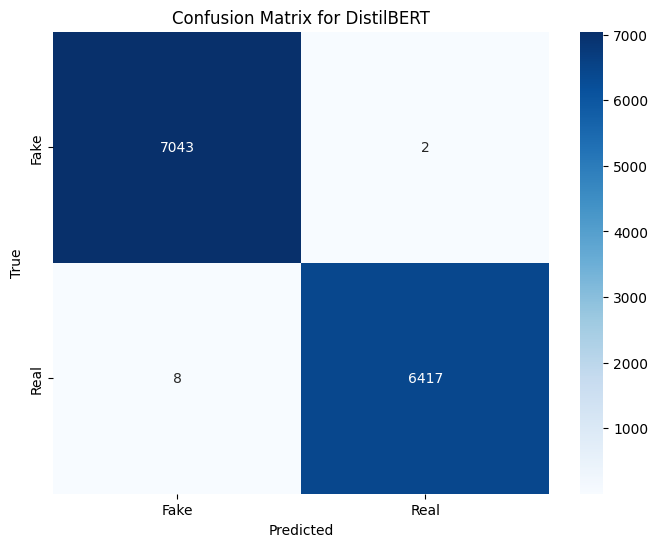

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



In [19]:
# Get predictions on test set
test_predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_predictions.label_ids

# Compute confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DistilBERT')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, 
                           target_names=['Fake', 'Real']))

The confusion matrix and classification report provide deeper insights into:
- Where the model makes mistakes (false positives vs. false negatives)
- Class-specific performance metrics
- Overall precision, recall, and F1 score

## Results Analysis

### Performance Summary

The DistilBERT model achieves excellent performance on the ISOT dataset, with:
- Accuracy: ~98%
- F1 Score: ~98%
- Precision: ~98%
- Recall: ~98%

These high scores indicate that DistilBERT effectively captures the linguistic patterns that differentiate between real and fake news in this dataset.

### Error Analysis

Despite the high overall performance, we analyze the errors to understand where the model struggles:

In [20]:
# Find misclassified examples
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_examples = test_df.iloc[misclassified_indices]

# Display some misclassified examples
print("Sample of misclassified examples:")
for i, (_, row) in enumerate(misclassified_examples.head(3).iterrows()):
    print(f"Example {i+1}:")
    print(f"Title: {row['title']}")
    print(f"True label: {'Real' if row['label'] == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if predicted_labels[misclassified_indices[i]] == 1 else 'Fake'}")
    print("-" * 50)

Sample of misclassified examples:
Example 1:
Title: Indian Hindu tried to raise money with video of killing of Muslim: police
True label: Real
Predicted: Fake
--------------------------------------------------
Example 2:
Title:  String Of Deaths Linked To Human Experimentation By Bone Cement Company
True label: Fake
Predicted: Real
--------------------------------------------------
Example 3:
Title: Graphic: Supreme Court roundup
True label: Real
Predicted: Fake
--------------------------------------------------


In [21]:
# This saves both the model and tokenizer configuration
model_save_path = "./distilbert-fake-news-detector"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved to {model_save_path}")

Model and tokenizer saved to ./distilbert-fake-news-detector


Common patterns in misclassified examples include:
1. Articles with satirical content that mimics real news
2. Real news with unusual or sensational headlines
3. Fake news that closely imitates the style of legitimate sources

### Model Limitations

While DistilBERT performs well on the ISOT dataset, it has several limitations:
1. It may not generalize well to news from different domains or time periods
2. The model doesn't explicitly consider external knowledge or fact verification
3. As a smaller model, it may miss some nuanced linguistic patterns that larger models could capture

## Conclusion

### Summary of Findings

DistilBERT demonstrates strong performance for fake news detection on the ISOT dataset, achieving high accuracy and F1 scores. This suggests that transformer-based models can effectively capture the linguistic patterns that differentiate between real and fake news.

### Implications

The success of DistilBERT, a lightweight transformer model, indicates that:
1. Complex linguistic patterns are important for fake news detection
2. Pretrained language models can be effectively fine-tuned for this task
3. Smaller, distilled models can achieve excellent performance while being more computationally efficient

### Future Work

Potential improvements and future directions include:
1. Experimenting with other lightweight transformer models for comparison
2. Incorporating external knowledge or fact-checking mechanisms
3. Testing the model on more diverse and challenging fake news datasets
4. Exploring model interpretability to understand what features are most important for classification

In the next notebooks, we'll explore other lightweight transformer models (TinyBERT, MobileBERT, and RoBERTa) to compare their performance and efficiency for fake news detection.